In [1]:
import torch,torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import pandas as pd
import wandb
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
PROJECT_NAME = 'Car-Object-Detection-V10-Learning-Detectron2-V2'

In [2]:
data = pd.read_csv('./data.csv')

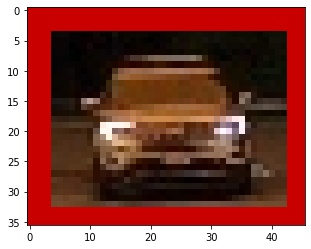

In [3]:
info = data.iloc[0]
img = cv2.imread(f'./data/{info["image"]}')
xmin,ymin,xmax,ymax = info['xmin'],info['ymin'],info['xmax'],info['ymax']
x = round(xmin)
y = round(ymin)
w = round(xmax - xmin)
h = round(ymax - ymin)
crop = img[y:y+h,x:x+w]
cv2.imwrite('./crop.png',crop)
cv2.rectangle(img,(x,y),(x+w,y+h),(200,0,0),5)
cv2.imwrite('img.png',img)
plt.imshow(img)
plt.imshow(crop)

In [4]:
info

image    vid_4_1000.jpg
xmin         281.259045
ymin         187.035071
xmax         327.727931
ymax         223.225547
Name: 0, dtype: object

In [5]:
def load_data():
    records = []
    for i in tqdm(range(len(data))):
        info = data.iloc[i]
        record = {}
        path = './data/' + info['image']
        record['height'],record['width'] = cv2.imread(path).shape[:2]
        record['file_name'] = path
        record['image_id'] = i
        record['annotations'] = [
            {
                'bbox':[info['xmin'],info['ymin'],info['xmax'],info['ymax']],
                'bbox_mode':BoxMode.XYXY_ABS,
                'category_id':0
            }
        ]
        records.append(record)
    np.save('./data.npy',records)
    return records

In [6]:
labels = ['Car']

In [7]:
DatasetCatalog.register('data',lambda : load_data())
MetadataCatalog.get('data').set(thing_classes=labels)
metadata = MetadataCatalog.get('data')

In [ ]:
wandb.init(project=PROJECT_NAME,name='baseline')
model = "COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model))
cfg.DATASETS.TRAIN = ('data')
cfg.DATASETS.TEST = ()
cfg.SOLVER.STEPS = []
cfg.SOLVER.MAX_ITER = 625
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(labels)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
cfg.MODEL.WEIGHTS = './output/model_final.pth'
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator('data',output_dir='./output/')
val_loader = build_detection_test_loader(cfg,'data')
metrics = inference_on_dataset(predictor.model,val_loader,evaluator)
wandb.log(metrics)
wandb.finish()

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-10-25 11:06:55.213610: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


[10/25 11:07:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

100%|████████████████████████████████████████| 559/559 [00:01<00:00, 330.48it/s]

[10/25 11:07:04 d2.data.build]: Removed 0 images with no usable annotations. 559 images left.
[10/25 11:07:04 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    Car     | 559          |
|            |              |
[10/25 11:07:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/25 11:07:04 d2.data.build]: Using training sampler TrainingSampler
[10/25 11:07:04 d2.data.common]: Serializing 559 elements to byte tensors and concatenating them all ...
[10/25 11:07:04 d2.data.common]: Serialized dataset takes 0.19 MiB



2021-10-25 11:07:05.290518: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model 

[10/25 11:07:06 d2.engine.train_loop]: Starting training from iteration 0
[10/25 11:07:12 d2.utils.events]:  eta: 0:02:56  iter: 19  total_loss: 1.565  loss_cls: 0.7252  loss_box_reg: 0.841  loss_rpn_cls: 0.009744  loss_rpn_loc: 0.005012  time: 0.2885  data_time: 0.0159  lr: 7.8424e-06  max_mem: 1687M
[10/25 11:07:18 d2.utils.events]:  eta: 0:02:56  iter: 39  total_loss: 1.542  loss_cls: 0.6577  loss_box_reg: 0.8434  loss_rpn_cls: 0.006778  loss_rpn_loc: 0.006113  time: 0.2968  data_time: 0.0026  lr: 1.5834e-05  max_mem: 1687M
[10/25 11:07:24 d2.utils.events]:  eta: 0:02:50  iter: 59  total_loss: 1.304  loss_cls: 0.5078  loss_box_reg: 0.7654  loss_rpn_cls: 0.007434  loss_rpn_loc: 0.005585  time: 0.2977  data_time: 0.0023  lr: 2.3826e-05  max_mem: 1687M
[10/25 11:07:30 d2.utils.events]:  eta: 0:02:44  iter: 79  total_loss: 1.199  loss_cls: 0.3959  loss_box_reg: 0.8173  loss_rpn_cls: 0.009621  loss_rpn_loc: 0.004983  time: 0.2969  data_time: 0.0024  lr: 3.1818e-05  max_mem: 1687M
[10/25 

100%|████████████████████████████████████████| 559/559 [00:01<00:00, 354.01it/s]

[10/25 11:10:16 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[10/25 11:10:16 d2.data.datasets.coco]: Conversion finished, #images: 559, #annotations: 559
[10/25 11:10:16 d2.data.datasets.coco]: Caching COCO format annotations at './output/data_coco_format.json' ...


100%|████████████████████████████████████████| 559/559 [00:01<00:00, 367.53it/s]


[10/25 11:10:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/25 11:10:18 d2.data.common]: Serializing 559 elements to byte tensors and concatenating them all ...
[10/25 11:10:18 d2.data.common]: Serialized dataset takes 0.19 MiB
[10/25 11:10:18 d2.evaluation.evaluator]: Start inference on 559 batches
[10/25 11:10:20 d2.evaluation.evaluator]: Inference done 11/559. Dataloading: 0.0006 s/iter. Inference: 0.2111 s/iter. Eval: 0.0001 s/iter. Total: 0.2118 s/iter. ETA=0:01:56
[10/25 11:10:25 d2.evaluation.evaluator]: Inference done 34/559. Dataloading: 0.0009 s/iter. Inference: 0.2208 s/iter. Eval: 0.0001 s/iter. Total: 0.2219 s/iter. ETA=0:01:56
[10/25 11:10:30 d2.evaluation.evaluator]: Inference done 56/559. Dataloading: 0.0009 s/iter. Inference: 0.2248 s/iter. Eval: 0.0001 s/iter. Total: 0.2259 s/iter. ETA=0:01:53
[10/25 11:10:35 d2.evaluation.evaluator]: Inference do

In [ ]:
torch.save(cfg,'cfg.pt')
torch.save(cfg,'cfg.pth')
torch.save(predictor,'predictor.pt')
torch.save(predictor,'predictor.pth')
torch.save(evaluator,'evaluator.pt')
torch.save(evaluator,'evaluator.pth')
torch.save(model,'model.pt')
torch.save(model,'model.pth')
torch.save(labels,'labels.pt')
torch.save(labels,'labels.pth')
torch.save(metrics,'metrics.pt')
torch.save(metrics,'metrics.pth')